# Spatial evolutionary game simulator

S. Kolotev, A. Malyutin, E. Burovski, S. Krashakov and L. Shchur, *Dynamic fractals in spatial evolutionary games*, Physica A **499**, 142 (2018)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation

%matplotlib notebook

In [2]:
import sys
import cython

print("python ", sys.version)
print("numpy", np.__version__, ", matplotlib", mpl.__version__, ", and Cython", cython.__version__)

python  3.5.2 (default, Nov 17 2016, 17:05:23) 
[GCC 5.4.0 20160609]
numpy 1.13.1 , matplotlib 2.0.2 , and Cython 0.27.3


## Main update function:

In [34]:
def evolve2(field, b, num_steps=1):
    L = field.shape[0]
    current = np.zeros((L, L), dtype=int)
    scores = np.zeros((L, L), dtype=float)
    
    for step in range(num_steps):
        current = field.copy()
        scores = np.zeros((L, L), dtype=float)
        
        for x in range(L):
            for y in range(L):
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        scores[x, y] += (1 - field[ix, jy])
                        
                if field[x, y] == 1:
                    scores[x, y] *= b
        
        for x in range(L):
            for y in range(L):
                bestX = x
                bestY = y
                for i in range(-1, 2):
                    for j in range(-1, 2):
                        ix = (x + i) % L
                        jy = (y + j) % L
                        if (scores[bestX, bestY] < scores[ix, jy]):
                            bestX = ix
                            bestY = jy
                
                field[x, y] = current[bestX, bestY]
    return field

### Run the simulation and animate

<IPython.core.display.Javascript object>


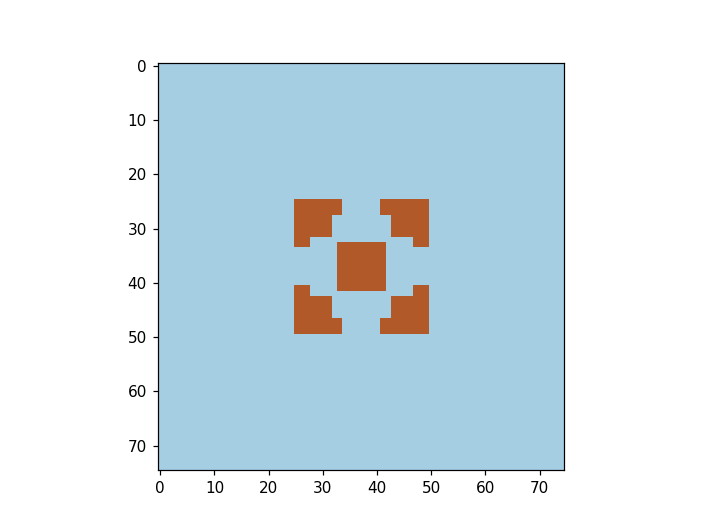

In [35]:
L = 75
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

# draw the initial field
fig = plt.figure()
im = plt.imshow(field, animated=True, cmap=plt.get_cmap('Paired'))

# updater function
def updatefig(*args):
    global field
    field = evolve2(field, 1.81, 1)
    im.set_array(field)
    return im,

# animate!
anim = animation.FuncAnimation(fig, updatefig, frames=200, interval=50, blit=True)

plt.show()

### Timings

In [5]:
L = 44
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

%timeit evolve2(field, 1.81, 10)

333 ms ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Enter Cython

In class, we started with the original code and did the conversion iteratively, removing yellow lines from the annotated output. Below is only the final result.

In [7]:
%load_ext cython

In [20]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp

import numpy as np
cimport cython

from cython.parallel cimport prange

@cython.boundscheck(False)
@cython.cdivision(True)
def evolve2_1(long[:, ::1] field, float b, int num_steps=1):
    
    cdef int x, y, L, i, j, ix, iy, jx, jy, step, bestX, bestY
    
    L = field.shape[0]
    cdef double[:, ::1] _zeros = np.zeros((L, L), dtype=float)
    cdef double[:, ::1] scores = np.zeros((L, L), dtype=float)
    
    cdef long[:, ::1] current = np.zeros((L, L), dtype=int)
    
    for step in range(num_steps):
        current = field.copy()
        scores[...] = _zeros
 
        with nogil:
            for x in prange(L):
                for y in range(L):
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            scores[x, y] += (1 - field[ix, jy])

                    if field[x, y] == 1:
                        scores[x, y] *= b

            for x in prange(L):
                for y in range(L):
                    bestX = x
                    bestY = y
                    for i in range(-1, 2):
                        for j in range(-1, 2):
                            ix = (x + i) % L
                            jy = (y + j) % L
                            if (scores[bestX, bestY] < scores[ix, jy]):
                                bestX = ix
                                bestY = jy
                    field[x, y] = current[bestX, bestY]
    return field

In [22]:
L = 75
field = np.zeros((L, L), dtype=int)
field[L//2, L//2] = 1

%timeit evolve2_1(field, 1.81, 10)

3.94 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
337 / 1.3

259.2307692307692

In [12]:
field[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [53]:
(field_2 == field).all()

True